# Compiler Optimization

## Setup

### Import Libraries

In [181]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm

### Variables

In [174]:
# Dataset
data_path = "/Users/cesar.salcedo/Documents/research/compiler_optimization/COBAYN/COBAYN/data"

# Hidden layer sizes for MLP
hs = [64, 64, 64]

# Learning Rate
lr = 0.001

# Epochs
num_epochs = 1

# Iterations
num_iterations = 1

## Dataset

In [85]:
# Load raw datasets
milepost = pd.read_csv(os.path.join(data_path, "ft_Milepost_cbench.csv"))
mica = pd.read_csv(os.path.join(data_path, "ft_MICA_cbench.csv"))
raw_runtimes = pd.read_csv(os.path.join(data_path, "cBench_onPandaboard_24app_5ds.csv"))

In [138]:
# Merge milepost and mica into single feature matrix
features = pd.merge(milepost, mica, how='inner', left_on=['APP_NAME','DATASET'], right_on=['APPLICATION_NAME','DATASET'])

In [139]:
# Transform runtimes to be in a mergable format
exe_labels = ["execution_time_" + str(i + 1) for i in range(5)]

frames = []
for i in range(5):
    ignored_labels = exe_labels[:]
    del ignored_labels[i]
    
    frame = raw_runtimes.drop(ignored_labels, axis=1)
    frame = frame.rename(columns={exe_labels[i] : "execution_time"})
    frame["DATASET"] = "dataset" + str(i + 1)
    frames.append(frame)
    
runtimes = pd.concat(frames, ignore_index=True)
runtimes = runtimes.drop(["code_size"], axis=1)

In [152]:
# Merge all together, one-hot encode dataset name, and replace strings by numbers
data = pd.merge(features, runtimes, how='inner', left_on=['APP_NAME','DATASET'], right_on=['APP_NAME','DATASET'])
data = pd.concat([pd.get_dummies(data["DATASET"]), data], axis=1)
data.drop(["APP_NAME", "APPLICATION_NAME", "DATASET"], axis=1, inplace=True)
data[data.columns[-8:-1]] = 1 * (data[data.columns[-8:-1]] != "X")
data

,dataset1,dataset2,dataset3,dataset4,dataset5,noBasicBlock,nobasicBlockSingleSocc,nobasicBlock2Socc,noBasicBlockSoccMore,noBasicBlockPred,...,mem_write_global_stride_512,mem_write_global_stride_4096,funsafe_math_optimizations,fno_guess_branch_probability,fno_ivopts,fno_tree_loop_optimize,fno_inline_functions,funroll_all_loops,o2,execution_time
0,1,0,0,0,0,129,37,31,0,61,...,15761599,15761792,0,0,0,0,0,0,0,2010.640
1,1,0,0,0,0,129,37,31,0,61,...,15761599,15761792,0,0,0,0,0,0,1,1777.070
2,1,0,0,0,0,129,37,31,0,61,...,15761599,15761792,0,0,0,0,0,1,0,2504.950
3,1,0,0,0,0,129,37,31,0,61,...,15761599,15761792,0,0,0,0,0,1,1,1715.030
4,1,0,0,0,0,129,37,31,0,61,...,15761599,15761792,0,0,0,0,1,0,0,1695.720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15355,0,0,0,0,1,3299,1486,1558,16,2205,...,4188468,4568914,1,1,1,1,0,1,1,246.399
15356,0,0,0,0,1,3299,1486,1558,16,2205,...,4188468,4568914,1,1,1,1,1,0,0,239.736
15357,0,0,0,0,1,3299,1486,1558,16,2205,...,4188468,4568914,1,1,1,1,1,0,1,190.470
15358,0,0,0,0,1,3299,1486,1558,16,2205,...,4188468,4568914,1,1,1,1,1,1,0,247.131


In [170]:
train_x = data.drop(["execution_time"], axis=1).to_numpy()
train_y = data[["execution_time"]].to_numpy()

print("x shape: {}".format(train_x.shape))
print("y shape: {}".format(train_y.shape))

x shape: (15360, 110)
y shape: (15360, 1)


## Model

In [187]:
# Layer sizes
ls = [x.shape[1]] + hs

model_list = []

for i in range(len(ls) - 1):
    model_list.append(nn.Linear(ls[i], ls[i + 1]))
    model_list.append(nn.ReLU())

model_list.append(nn.Linear(ls[len(ls) - 1], 1))

model = nn.Sequential(*model_list)

### Optimizer and Criterion

In [188]:
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=lr)

## Training loop

In [189]:
losses = []

for epoch in tqdm(range(num_epochs)):
    for i in tqdm(range(len(train_x))):
        x = torch.Tensor(train_x[i:i+1])
        y = torch.Tensor(train_y[i:i+1])
        
        y_hat = model(x)
        
        loss = criterion(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15360 [00:00<?, ?it/s]

## Plots

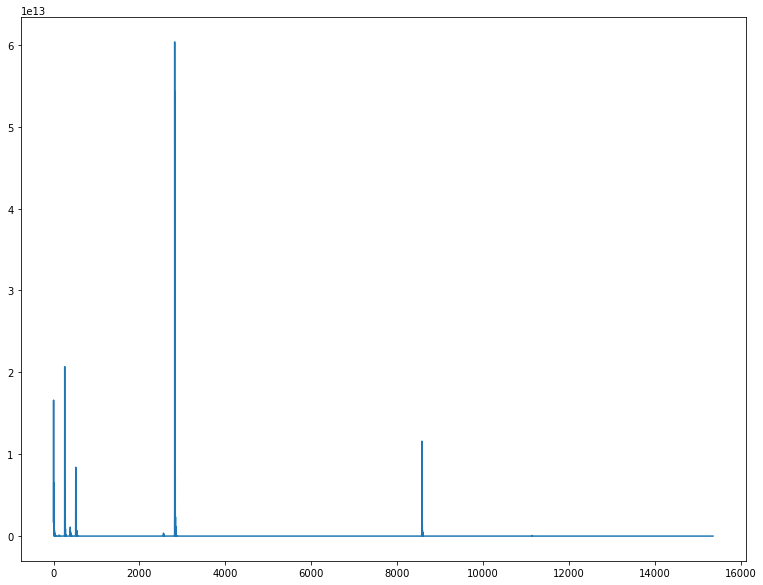

In [190]:
fig = plt.figure(figsize=(13,10))
plt.plot(losses)
plt.show()
plt.close(fig)